In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

# Read data and build subnetwork

In [3]:
def get_yeastract_data(yeastract_csv_filename, gene_to_orf_filename="tftoorf.csv", as_orf=False):
    '''
    Returns Yeastract network data as a pandas DataFrame.
    '''
    def tf_to_gene(tf_name):
        '''
        Removes trailing "p" from transcription factor name and turn into uppercase.
        '''
        if tf_name[-1] == 'p':
            return tf_name.upper()[:-1]
        else:
            return tf_name
    
    yeastract_data = pd.read_csv(yeastract_csv_filename, sep= ";")
    gene_to_orf_df = pd.read_csv(gene_to_orf_filename)
    
    tf_list = list(yeastract_data['6855'])
    gene_list = list(yeastract_data.columns.values)[1:]
    
    # Fix dataframe so it has right things as rownames.
    yeastract_data = yeastract_data.rename(index=yeastract_data['6855'])
    yeastract_data = yeastract_data.iloc[:, 1:]
    
    tf_list = [tf_to_gene(tf) for tf in tf_list]
    if as_orf:
        gene_to_orf = dict(zip(list(gene_to_orf_df.iloc[:,0]), list(gene_to_orf_df.iloc[:,2])))
        
        rownames = [gene_to_orf[tf] for tf in tf_list]
        # Change to TF if possible, otherwise keep same name.
        colnames = [gene_to_orf.get(gene, gene) for gene in gene_list]
    else:
        rownames = tf_list
        colnames = gene_list
    
    final_data = pd.DataFrame(np.array(yeastract_data), index=rownames, columns=colnames)
    
    return final_data

def get_gasch_data(gasch_data_filename="complete_dataset_gasch.txt", 
                   orf_to_gene_filename="orfname_time_course_fixed.csv",
                   supset=None ,
                   as_orf=False):
    '''
    Returns heat shock time-course data from Gasch as DataFrame.
    '''
    gasch_data = pd.read_csv(gasch_data_filename, sep="\t")
#    gasch_data = gasch_data.iloc[:,:11] # Filter only heat-shock data from first experiment (hs-1).
    
    if not as_orf:
        # Rename as genes.
        orf_to_gene_df = pd.read_csv(orf_to_gene_filename)
        orfs = list(orf_to_gene_df.iloc[:,0])
        genes = list(orf_to_gene_df.iloc[:,3])
        
        # Remove unknowns, keep original name.
        genes = [gene if gene != 'Unknown' else orfs[i] for i, gene in enumerate(genes)]
        orf_to_gene = dict(zip(orfs, genes))
        
        orf_list = list(gasch_data["UID"])
        gene_names = [orf_to_gene.get(orf, orf) for orf in orf_list]
        #print(gene_names)
        gasch_data["UID"] = gene_names
        gasch_data = gasch_data.rename(index=gasch_data["UID"])
        gasch_data = gasch_data.iloc[:, 1:]
        if supset != None:
            to_delete = set(gene_names)-set(supset)
            to_delete_list = list(to_delete)
            gasch_data = gasch_data.drop(to_delete_list)
    return gasch_data
    

def squarify(df, sort=False):
    '''
    Turns Yeastract DataFrame into a square dataframe (i.e. adjacency matrix).
    '''
    cols=list(df.columns)
    rows=list(df.index)
    d = []
    for x in cols:
        if x in rows:
            d.append(list(df.loc[x]))
        else:
            d.append([0]*len(cols))
    A = np.array(d)
    return pd.DataFrame(A, index=cols, columns=cols)

def reorder(target_orf, adj_matrix):
    A = target_orf #input the list of target orf name
    B = adj_matrix #input the adj matrix

    #First we want to extract the header from the adj matrix and compare them with the list

    B_header = list(B)

    AB_diff = list(set(B_header) - set(A))
    #print(set(A)<set(B_header))
    A_total = A + AB_diff
    B = B[A_total]
    B = B.reindex(A_total)
    return B

In [4]:
# Read network data.
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)

In [ ]:
W = adj_matrix

network = nx.DiGraph(data=np.array(W))
names = list(W)
network = nx.relabel_nodes(network, {i:name for i, name in enumerate(names)})

In [5]:
def get_neighbors_subnetwork(network_act, network_inh, starters):
    '''
    network_act: Network of activators, network of inhibitors.
    
    Returns activator and inhibitor networks with starter nodes and direct downstream neighbors
    (whether activators or inhibitors).
    '''
    neighbors = []
    for tf in starters:
        neighbors.extend(list(network_act.successors(tf)))
        neighbors.extend(list(network_inh.successors(tf)))
      
    all_nodes = starters + neighbors
    # Remove duplicates.
    all_nodes = list(set(all_nodes))
    return network_act.subgraph(all_nodes), network_inh.subgraph(all_nodes)

In [6]:
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))
names = list(Aa)

network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

Since we're using different constants, we need to get the activator and inhibitor networks separately.

In [7]:
#These transcription factors are the ones we expect to turn on the heat shock response.
heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]

G1_act, G1_inh = get_neighbors_subnetwork(network_act, network_inh, ['HSF1'])

### Model definition for heat shock subnetwork

In [8]:
# Get activator and inhibitor matrices for subnetwork.
Aa_hsf = nx.adjacency_matrix(G1_act).toarray()
Ai_hsf = nx.adjacency_matrix(G1_inh).toarray()

# Take transpose to match what we need for modeling.
Aa_hsf, Ai_hsf = Aa_hsf.transpose(), Ai_hsf.transpose()

In [9]:
len(Aa_hsf)

121

In [10]:
len(Ai_hsf)

121

In [11]:
nodes = list(set(list(G1_act.nodes()) + list(G1_inh.nodes())))

In [12]:
# Model 1: mRNA only, separate inhibition and activation.
def f(y, t0, u, ka, ki, kf, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return A @ y - kf * y + u

# Model 2: mRNA only, separate inhibition and activation, max activation (tanh).
def f2(y, t0, u, ka, ki, kf, k_max, k_width, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return k_max * np.tanh((A @ y) / k_width) - kf * y + u

# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, ka, ki, kf, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = (A @ p) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

# Model 4: mRNA and protein, separate inhibition and activation, max activation (tanh).
def f4(y, t0, u, ka, ki, kf, k_max, k_width, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = k_max * np.tanh(A @ p / k_width) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

### Brief model test

This is just a test to see if the modifications I did to the model change anything or not.

#### Ka and Ki

In [13]:
u = 0.05 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_act.nodes()])
y0 = [0.0] * len(Aa_hsf)
times = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

kf = [0.1] * len(Aa_hsf)
y = odeint(f, y0=y0, t=times, args=(u, 0.3, 0.3, kf, Aa_hsf, Ai_hsf))

In [14]:
nodes = list(G1_act.nodes())
hsf_index = nodes.index("HSF1")

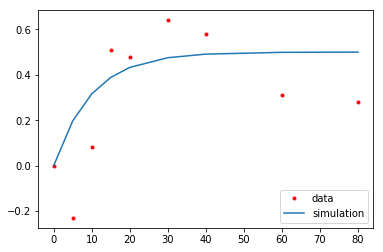

In [15]:
real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

### Protein model.

In [16]:
u = 0.03 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_act.nodes()])
y0 = [0.0] * len(Aa_hsf) * 2
times = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

kf = [0.1] * len(Aa_hsf)
k_prot = 0.08
y = odeint(f3, y0=y0, t=times, args=(u, 0.3, 0.3, kf, k_prot, Aa_hsf, Ai_hsf))

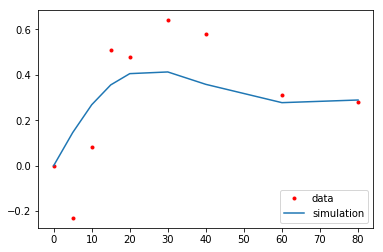

In [17]:
real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

OK, so this seems to be working. Now let's try and do the error function.

In [206]:
def error(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, Aa_hsf, Ai_hsf))
    
    # Calculate absolute error.
    err = np.abs(y - y_data)
    
    # Threshold error to remove undue influence of nodes that blow up.
    err = np.minimum(err, 2)
    return np.nanmean(err)

def error2(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width = params[-5:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f2, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, k_max, k_width, Aa_hsf, Ai_hsf))
    
    # Return mean absolute error.
    return np.nanmean(np.abs(y - y_data))

def error3(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_prot = params[-4:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, k_prot, Aa_hsf, Ai_hsf))
    m = y[:,:N]
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def error4(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width, k_prot = params[-6:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f4, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, k_max, k_width, k_prot, Aa_hsf, Ai_hsf))
    m = y[:,:N]
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

In [194]:
np.maximum([1,2,3], 2)

array([2, 2, 3])

## Test error function

First, we need to get the real data in a format we can use.

In [198]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
y_data = np.array(y_data).transpose()

In [199]:
N = len(nodes)
hss_indices = [nodes.index('HSF1')]
params = np.array([0.05, 0.1, 0.3, 0.3, 0.1])

In [200]:
hss_indices

[41]

In [66]:
errors = error2(params, y_data, N, hss_indices, n_hss=1)

In [67]:
hsf_index

41

In [207]:
fit_params = minimize(error, x0=np.array([0.02, 0.1, 0.3, 0.3, 0.1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5)])

In [204]:
fit_params

      fun: 1.0052854191947471
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00089411,  0.00077327, -0.00084879,  0.00300597,  0.00076925])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 666
      nit: 39
   status: 0
  success: True
        x: array([ 2.9790927 ,  3.44440626,  4.56696003,  0.01      ,  4.9999968 ])

In [205]:
fit_params.x

array([ 2.9790927 ,  3.44440626,  4.56696003,  0.01      ,  4.9999968 ])

In [70]:
fit_params2 = minimize(error2, x0=np.array([0.02, 0.1, 0.3, 0.3, 0.1, 1, 1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0, 5),
                          (0, 5)])

In [71]:
fit_params2

      fun: 0.93999999999999995
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 1
   status: 0
  success: True
        x: array([ 0.02,  0.1 ,  0.3 ,  0.01,  0.1 ,  1.  ,  1.  ])

In [72]:
fit_params3 = minimize(error3, x0=np.array([0.05, 0.1, 0.3, 0.3, 0.1, 0.1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0, 5)])

In [73]:
fit_params3.x

array([  5.00000000e+00,   1.00000000e-03,   5.00000000e+00,
         2.99999955e-01,   1.00000000e-03,   6.06709690e-07])

In [74]:
fit_params4 = minimize(error4, x0=np.array([0.05, 0.1, 0.3, 0.3, 0.1, 0.5, 0.5, 0.1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5)])

In [75]:
fit_params4.x

array([ 0.001     ,  0.3467039 ,  0.001     ,  0.001     ,  0.34456506,
        0.001     ,  0.46290426,  0.001     ])

In [76]:
def get_predictions(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f, y0=y0, t=times,
               args=(u, ka, ki, kf, Aa_hsf, Ai_hsf))
    return y

def get_predictions2(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width = params[-5:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f2, y0=y0, t=times,
               args=(u, ka, ki, kf, k_max, k_width, Aa_hsf, Ai_hsf))
    return y

def get_predictions3(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_prot = params[-4:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, ka, ki, kf, k_prot, Aa_hsf, Ai_hsf))
    return y[:,:N]

def get_predictions4(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width, k_prot = params[-6:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f4, y0=y0, t=times,
               args=(u, ka, ki, kf, k_max, k_width, k_prot, Aa_hsf, Ai_hsf))
    return y[:,:N]

In [91]:
ts = np.linspace(0, 80, 1000)


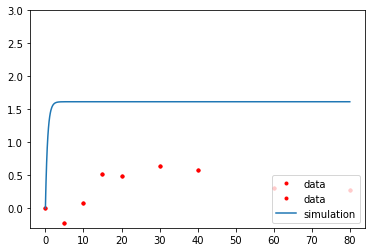

In [93]:
y_pred = get_predictions(fit_params.x,
                        times=ts)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(ts, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.ylim(-0.3, 3)
plt.show()

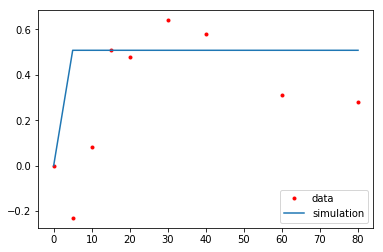

In [49]:
y_pred = get_predictions(fit_params.x)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

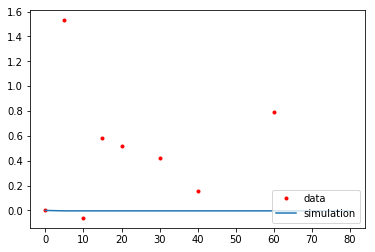

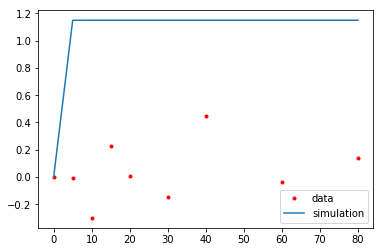

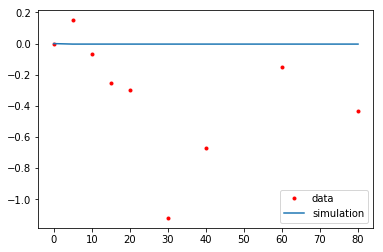

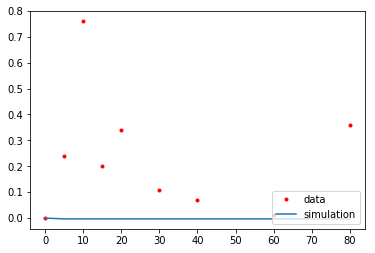

In [94]:
y_pred = get_predictions(fit_params.x)
for i in range(0, 4):
    real_data = gasch_data.iloc[:, 2:10].iloc[i,:]
    plt.plot(times, [0] + list(real_data), '.r', label="data")
    plt.plot(times, y_pred[:, i], '-', label="simulation")
    plt.legend(loc="lower right")
    plt.show()

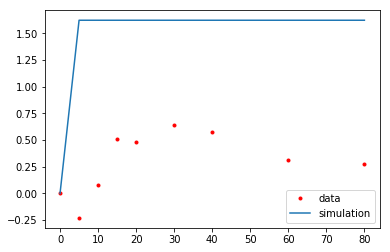

In [34]:
y_pred = get_predictions3(fit_params3.x)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

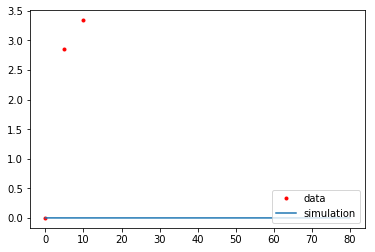

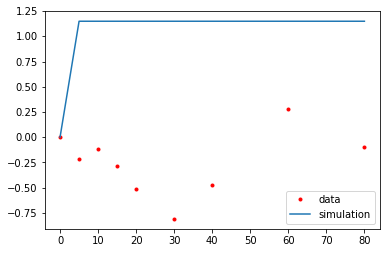

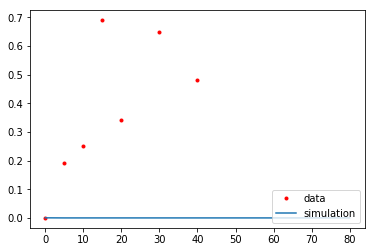

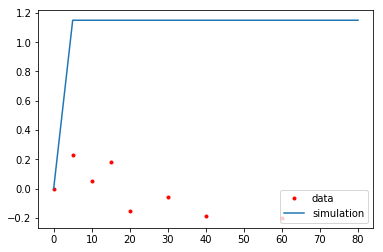

In [35]:
y_pred = get_predictions3(fit_params3.x)
for i in range(4, 8):
    real_data = gasch_data.iloc[:, 2:10].iloc[i,:]
    plt.plot(times, [0] + list(real_data), '.r', label="data")
    plt.plot(times, y_pred[:, i], '-', label="simulation")
    plt.legend(loc="lower right")
    plt.show()

In [36]:
error(np.array([0.0, 0.5, 0.3, 0.3, 0.1]), y_data, N, hss_indices, n_hss=1)

1.486396292004635

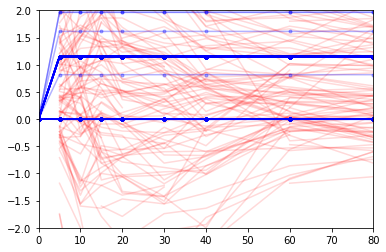

In [95]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-r', alpha=0.15)
plt.plot(times, y_pred, '.-b', alpha=0.3)
plt.xlim(0, 80)
plt.ylim(-2, 2)
plt.show()

In [38]:
np.concatenate((np.array([1,2]), np.array([3,4])))

array([1, 2, 3, 4])

# Fit HSS separately

So our model after parameter fitting is ~~complete and utter shit~~ not very good. It's giving us terrible behavior (some things blow up), and it takes forever to run. Because of this it may be a better idea to fit the HSS parameters separately. Enter this section!

In [129]:
def h1(y, t0, u0, kf0):
    '''
    Model of single HSS (mRNA only).
    '''
    return -kf0 * y + u0

def h3(y, t0, u0, kf0, k_prot):
    '''
    Model of single HSS (mRNA and protein).
    '''
    m, p = y
    dm = -kf0 * p + u0
    dp = k_prot * (m - p)
    return np.array([dm, dp])

In [132]:
def error_hss(params, y_data, prot):
    '''
    Model error for heat shock starters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[0]
    # Feedback strength for HSS.
    kf0 = params[1]
    # General activation, inhibition and feedback constants.
    if prot:
        k_prot = params[2]
        h = h3
        args = (u0, kf0, k_prot)
        y0 = np.zeros(2)
    else:
        h = h1
        args = (u0, kf0)
        y0 = np.zeros(1)
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    #print(args)
    y = odeint(h, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=args)
    
    # Return mean absolute error.
    if prot:
        m = y[:, 0]
    else:
        m = y
    return np.nanmean(np.abs(m - y_data))



In [163]:
fits = {'mRNA':{}, 'prot':{}}
for tf in heat_shock_starters:
    real_data = gasch_data.iloc[:, 2:10].loc[tf]
    real_data = np.array(real_data).transpose()
    fits['mRNA'][tf] = minimize(error_hss, x0=np.array([0.05, 0.1]),
                         args=(real_data, False), method = 'Nelder-Mead')
                      #bounds=[(0, 5),
                      #        (0, 5)])
    fits['prot'][tf] = minimize(error_hss, x0=np.array([0.05, 0.1, 0.1]),
                                args=(real_data, True), method = 'Nelder-Mead')
                      #bounds=[(0, 5),
                      #        (0, 5),
                      #        (0, 5)])
    

In [164]:
fits

{'mRNA': {'HSF1':  final_simplex: (array([[ 0.14953693,  0.36527272],
       [ 0.14956217,  0.3653361 ],
       [ 0.14956267,  0.36533547]]), array([ 0.2421875,  0.2421875,  0.2421875]))
           fun: 0.24218749999999994
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 30
        status: 0
       success: True
             x: array([ 0.14953693,  0.36527272]),
  'MSN2':  final_simplex: (array([[ 0.08203582,  0.62124098],
       [ 0.08202831,  0.62118392],
       [ 0.08203306,  0.62122019]]), array([ 0.200625,  0.200625,  0.200625]))
           fun: 0.20062499999999997
       message: 'Optimization terminated successfully.'
          nfev: 106
           nit: 42
        status: 0
       success: True
             x: array([ 0.08203582,  0.62124098]),
  'MSN4':  final_simplex: (array([[ 0.26861747,  0.30913338],
       [ 0.26854824,  0.30906252],
       [ 0.26855557,  0.30906727]]), array([ 0.675625,  0.675625,  0.675625]))
           fun: 0.67

In [165]:
def error_hss(params, y_data, prot):
    '''
    Model error for heat shock starters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[0]
    # Feedback strength for HSS.
    kf0 = params[1]
    # General activation, inhibition and feedback constants.
    if prot:
        k_prot = params[2]
        h = h3
        args = (u0, kf0, k_prot)
        y0 = np.zeros(2)
    else:
        h = h1
        args = (u0, kf0)
        y0 = np.zeros(1)
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    #print(args)
    y = odeint(h, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=args)
    
    # Return mean absolute error.
    if prot:
        m = y[:, 0]
    else:
        m = y
    return np.nanmean(np.abs(m - y_data))

In [213]:
def plot_hss(hss, fits, ts):
    params_rna = tuple(fits['mRNA'][hss].x)
    params_prot = tuple(fits['prot'][hss].x)
    
    #print(params_rna)
    y_rna = odeint(h1, y0=np.array([0]), t=ts,
                  args=params_rna)
    
    y_prot = odeint(h3, y0=np.array([0, 0]), t=ts,
                  args=params_prot)

    real_data = gasch_data.iloc[:, 2:10].loc[hss]
    plt.plot(times[1:], list(real_data), '.r', label="data")
    plt.plot(ts, y_rna, '-', label="mRNA")
    plt.plot(ts, y_prot[:, 0], '-', label="prot")
    plt.title(hss)
    #plt.ylim(-1.7, 1.7)
    plt.legend(loc="best")
    plt.show()
    

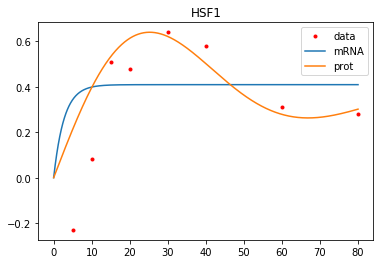

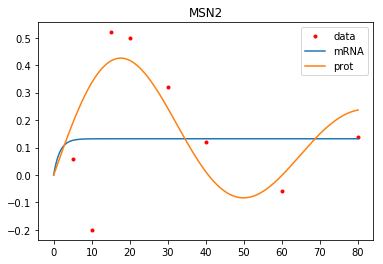

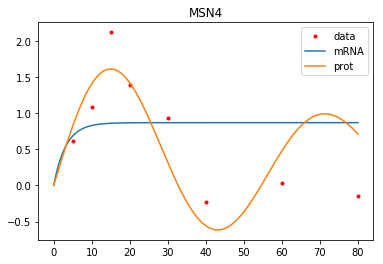

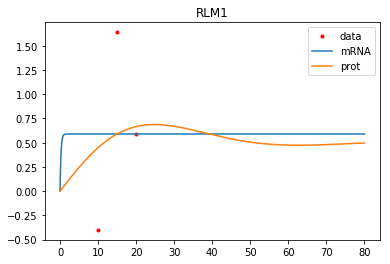

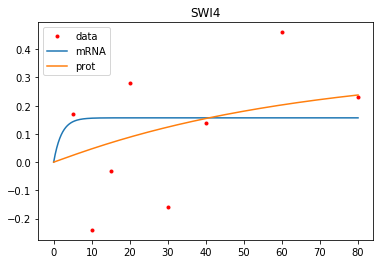

In [214]:
for tf in heat_shock_starters:
    plot_hss(tf, fits, ts)

In [182]:
rna_file = open('hss_params_rna.csv', 'w')
header = 'tf, u0, kf0\n'

print(header)
rna_file.write(header)
for tf in heat_shock_starters:
    par = fits['mRNA'][tf].x
    outstring = tf +',' + ','.join([str(p) for p in par]) + '\n'
    print(outstring)
    rna_file.write(outstring)
rna_file.close()

tf, u0, kf0

HSF1,0.149536926746,0.365272722244

MSN2,0.0820358163677,0.621240983056

MSN4,0.26861746788,0.309133377075

RLM1,2.48024542538,4.20380580574

SWI4,0.0757537286262,0.482931825091



In [183]:
prot_file = open('hss_params_prot.csv', 'w')
header = 'tf, u0, kf0, k_prot\n'

print(header)
prot_file.write(header)
for tf in heat_shock_starters:
    par = fits['prot'][tf].x
    outstring = tf +',' + ','.join([str(p) for p in par]) + '\n'
    print(outstring)
    prot_file.write(outstring)
prot_file.close()

tf, u0, kf0, k_prot

HSF1,0.0436405966436,0.121945508189,0.0523456275768

MSN2,0.0392442904743,0.343173321625,0.0281788889963

MSN4,0.172861821258,0.543289018822,0.0232096159202

RLM1,0.0507078354245,0.0998609134756,0.0884396362324

SWI4,0.00486403607494,0.0146434078813,0.213830584551

